Hackstory ML


In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from imblearn.over_sampling import SMOTE


In [120]:

rawdata = pd.read_csv('income_train.csv')


In [121]:
rawdata = rawdata.drop(
    ['signature_id', 'capital-gain', 'capital-loss'], axis=1)


In [122]:
rawdata.replace('?', np.nan, inplace=True)

for column in rawdata.columns:
    if rawdata[column].isnull().sum() > 0:
        if rawdata[column].dtype == 'object':
            # Replace missing values with mode
            mode = rawdata[column].mode()[0]
            rawdata[column].fillna(mode, inplace=True)
        else:
            # Replace missing values with mean
            mean = rawdata[column].mean()
            rawdata[column].fillna(mean, inplace=True)

rawdata.to_csv('updated_dataset.csv', index=False)


In [123]:
data = pd.read_csv('updated_dataset.csv')

# Biases Analysis - Race
race_counts = data['race'].value_counts()
race_percentages = race_counts / len(data) * 100
print("Race Distribution:")
print(race_percentages)

# Biases Analysis - Gender
gender_counts = data['gender'].value_counts()
gender_percentages = gender_counts / len(data) * 100
print("\nGender Distribution:")
print(gender_percentages)

# Biases Analysis - Native Country
country_counts = data['native-country'].value_counts()
country_percentages = country_counts / len(data) * 100
print("\nNative Country Distribution:")
print(country_percentages)


Race Distribution:
White                 85.425563
Black                  9.631471
Asian-Pac-Islander     3.112021
Amer-Indian-Eskimo     0.956420
Other                  0.874525
Name: race, dtype: float64

Gender Distribution:
Male      68.046212
Female    31.953788
Name: gender, dtype: float64

Native Country Distribution:
United-States                 91.485815
Mexico                         1.956712
Philippines                    0.608365
Germany                        0.412401
Puerto-Rico                    0.386078
Canada                         0.353905
El-Salvador                    0.324656
India                          0.321732
Cuba                           0.289558
China                          0.266160
England                        0.245686
South                          0.225212
Jamaica                        0.222287
Italy                          0.213513
Columbia                       0.204738
Dominican-Republic             0.201813
Poland                         0.

In [130]:
# Replace letters with NaN
data['educational-num'] = pd.to_numeric(
    data['educational-num'], errors='coerce')

average = data['educational-num'].mean()

round_avg = round(average)
# Replace NaN values with the average
data['educational-num'].fillna(int(round_avg), inplace=True)
data.to_csv('updated_dataset.csv', index=False)


In [131]:
data_updt = pd.read_csv('updated_dataset.csv')

threshold = 0.1
total_count = len(data_updt)
count_threshold = total_count * threshold
country_distribution = data_updt['native-country'].value_counts() / total_count
rare_categories = country_distribution[country_distribution < threshold].index.tolist()
data_updt['native-country'] = data_updt['native-country'].apply(lambda x: 'Other' if x in rare_categories else x)

data_updt.to_csv('updated_dataset.csv', index=False)

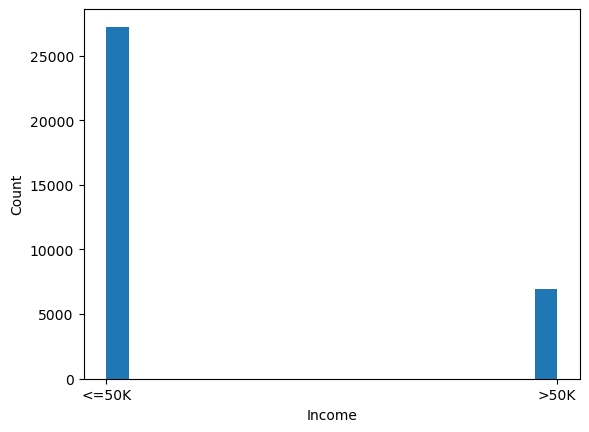

In [128]:
# Visualize income distribution
plt.hist(data['income'], bins=20)
plt.xlabel('Income')
plt.ylabel('Count')
plt.show()


In [129]:
from sklearn.preprocessing import LabelEncoder

data_updt = pd.read_csv('updated_dataset.csv')

label_encoder = LabelEncoder()

mappings = {}

for column in data_updt.columns:
    if data_updt[column].dtype == 'object':
        value_counts = data_updt[column].value_counts()
        sorted_values = value_counts.index.tolist()
        encoded_values = label_encoder.fit_transform(sorted_values)

        # Mapping dictionary with keys in descending order of frequencies and values in ascending order
        mapping = dict(zip(sorted_values, range(len(sorted_values))))
        
        data_updt[column] = data_updt[column].map(mapping)
        mappings[column] = mapping

# Save it as a new CSV file
data_updt.to_csv('encoded_dataset.csv', index=False)

for column, mapping in mappings.items():
    print(f"Mapping for column '{column}':")
    sorted_mapping = {k: v for k, v in sorted(mapping.items(), key=lambda item: item[1])}
    print(sorted_mapping)
    print()

Mapping for column 'workclass':
{'Private': 0, 'Self-emp-not-inc': 1, 'Local-gov': 2, 'State-gov': 3, 'Self-emp-inc': 4, 'Federal-gov': 5, 'Without-pay': 6, 'Never-worked': 7}

Mapping for column 'education':
{'HS-grad': 0, 'Some-college': 1, 'Bachelors': 2, 'Masters': 3, 'Assoc-voc': 4, '11th': 5, 'Assoc-acdm': 6, '10th': 7, '7th-8th': 8, 'Prof-school': 9, '9th': 10, '12th': 11, 'Doctorate': 12, '5th-6th': 13, '1st-4th': 14, 'Preschool': 15}

Mapping for column 'educational-num':
{'9': 0, '10': 1, '13': 2, '14': 3, '11': 4, '7': 5, '12': 6, '6': 7, '4': 8, '15': 9, '5': 10, '8': 11, '16': 12, '3': 13, '2': 14, 'Z': 15, 'N': 16, 'U': 17, 'X': 18, 'S': 19, 'I': 20, 'P': 21, 'V': 22, 'A': 23, 'D': 24, 'R': 25, 'Q': 26, 'C': 27, 'H': 28, 'G': 29, 'M': 30, 'Y': 31, 'L': 32, 'O': 33, 'K': 34, 'W': 35, 'T': 36, 'F': 37, 'J': 38, 'E': 39, 'B': 40, '1': 41}

Mapping for column 'marital-status':
{'Married-civ-spouse': 0, 'Never-married': 1, 'Divorced': 2, 'Separated': 3, 'Widowed': 4, 'Married-

In [103]:
from sklearn.metrics import accuracy_score
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import parallel_backend
import pandas as pd

bias_data = pd.read_csv('encoded_dataset.csv')

X = bias_data.drop(['income'], axis=1)
y = bias_data['income']

gender_index = list(X.columns).index('gender')
race_index = list(X.columns).index('race')

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

constraint = DemographicParity()

classifier = RandomForestClassifier(class_weight='balanced')
with parallel_backend('threading'):
    unbiased_model = ExponentiatedGradient(classifier, constraint)
    unbiased_model.fit(X_train, y_train, sensitive_features=X_train[:, [gender_index, race_index]])

y_pred = unbiased_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print(f'Accuracy for the fair model: {accuracy * 100:.2f}%')

Accuracy for the fair model: 75.91%


In [109]:
df = pd.read_csv('encoded_dataset.csv')

df['income'].unique()

X = df.drop(['income', 'race'], axis=1)
y = df['income']

# Compute weights based on 'fnlwgt'
weights = X['fnlwgt'] / X['fnlwgt'].sum()

smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)
sample_weights_resampled, _ = smote.fit_resample(weights.to_frame(), y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
sample_weights_train, sample_weights_test = train_test_split(sample_weights_resampled, test_size=0.2, random_state=42)

model = RandomForestClassifier(class_weight='balanced')
model.fit(X_train, y_train, sample_weight=sample_weights_train.values.ravel())

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy considering final weights: {accuracy * 100:.4f}%')

classes = {0:'Income lower than 50k', 1:'Income greater than or equal to 50K'}

class_labels = list(classes.values())

test_input = {
    'age': [43],
    'workclass': [3],
    'fnlwgt': [1],
    'education': [15],
    'educational-num': [13.0],
    'marital-status': [2],
    'occupation': [11],
    'relationship': [0],
    'race': [1],
    'gender': [1],
    'hours-per-week': [45],
    'native-country': [38]
}

# Converting the test input dictionary to a DataFrame
test_df = pd.DataFrame(test_input)

predicted_income = model.predict(test_df)

if predicted_income == [0]:
    print("Income rage: <=50k")
elif predicted_income == [1]:
    print("Income range: >50k")
else:
    print("Cannot predict") 


Accuracy considering final weights: 88.5809%
Income range: >50k


In [111]:
df = pd.read_csv('encoded_dataset.csv')

X = df.drop(['income'], axis=1)
y = df['income']

# Compute weights based on 'fnlwgt'
weights_fnlwgt = X['fnlwgt'] / X['fnlwgt'].sum()

# Calculate weights based on 'gender' column
gender_counts = X['gender'].value_counts()
total_samples = len(X)
weights_gender = total_samples / (2 * gender_counts)

weights_combined = []

for index, row in X.iterrows():
    if row['gender'] == 0:
        weight = weights_fnlwgt[index] * weights_gender[0]
    elif row['gender'] == 1:
        weight = weights_fnlwgt[index] * weights_gender[1]
    weights_combined.append(weight)

weights_combined = pd.DataFrame(weights_combined, columns=['weights'])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)
sample_weights_resampled, _ = smote.fit_resample(weights_combined, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
sample_weights_train, sample_weights_test = train_test_split(sample_weights_resampled, test_size=0.2, random_state=42)

model = RandomForestClassifier(class_weight = 'balanced')
model.fit(X_train, y_train, sample_weight=sample_weights_train.values.ravel())

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy considering final weights: {accuracy * 100:.4f}%')

classes = {0:'Income lower than 50k', 1:'Income greater than or equal to 50K'}

class_labels = list(classes.values())

test_input = {
    'age': [43],
    'workclass': [3],
    'fnlwgt': [1],
    'education': [15],
    'educational-num': [13.0],
    'marital-status': [2],
    'occupation': [11],
    'relationship': [0],
    'gender': [1],
    'hours-per-week': [45],
    'native-country': [38]
}

# Convert the test input dictionary to a DataFrame
test_df = pd.DataFrame(test_input)

predicted_income = model.predict(test_df)

if predicted_income == [0]:
    print("Income range: <=50k")
elif predicted_income == [1]:
    print("Income range: >50k")
else:
    print("Cannot predict") 


Accuracy considering final weights: 88.4891%
Income range: <=50k


In [105]:
import pickle
filename = "trained_model.sav"
pickle.dump(model, open(filename, 'wb'))